In [1]:
import pandas as pd
import numpy as np
import calendar
from time import time
from datetime import datetime
import re 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_train = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
#data_train_orig = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")

In [3]:
dept_list = sorted(list(data_train.DepartmentDescription.dropna().unique()))

In [4]:
weekdays = list(calendar.day_name)
dept_list_sum = dict.fromkeys(dept_list, np.sum)
weekday_dict = dict.fromkeys(weekdays, np.max)
feature_dict = {"TripType": np.max, 'NumItems': np.sum, 'Return': np.max}
feature_dict = {**feature_dict, **weekday_dict, **dept_list_sum}

In [5]:
def transform_data(data):
    dummies = pd.get_dummies(data.Weekday)
    data[dummies.columns] = dummies
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    dummies = dummies.apply(lambda x: x*data["ScanCount"])
    data[dummies.columns] = dummies 

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    
    data = data.rename(columns={"ScanCount":"NumItems"})
    
    grouped = data.groupby("VisitNumber")
    grouped = grouped.aggregate(feature_dict)
    data = grouped[["TripType", "NumItems", "Return"] + weekdays + dept_list]

    return data

In [6]:
data_new = transform_data(data_train)

In [7]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.loc[:, dept_list[0]:]):
        count = 0
        count = sum(x > 0 for x in array)
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [8]:
data_new = add_category_counts(data_new)

In [9]:
data_new.shape

(95674, 78)

In [10]:
def fineline_dummies(data):
    values = data.FinelineNumber
    counts = values.value_counts()
    mask = values.isin(counts[counts > 500].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['fln_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [11]:
start = datetime.now()
fln_dummies = fineline_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:14.553735'

In [12]:
data_new = data_new.join(fln_dummies)

In [13]:
data_new.shape

(95674, 351)

In [14]:
def Upc_dummies(data):
    values = data.Upc
    counts = values.value_counts()
    mask = values.isin(counts[counts > 300].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['upc_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [15]:
start = datetime.now()
upc_dummies = Upc_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:05.561673'

In [16]:
data_new = data_new.join(upc_dummies)

In [17]:
data_new.shape

(95674, 451)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [19]:
X = data_new.drop('TripType', axis=1)

trip_types = sorted(data_train.TripType.unique())
trip_types_map = dict(zip(trip_types, np.arange(0, len(trip_types))))
y = data_new.TripType.map(trip_types_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
def create_model_4hl(nodes_l1=512, nodes_l2=256, nodes_l3=128, nodes_l4=64, dropout_l1=0.3, dropout_l2=0.3, dropout_l3=0.2, dropout_l4=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
    model.add(Dense(output_dim=nodes_l3, activation="relu"))
    model.add(Dropout(dropout_l3))
    model.add(Dense(output_dim=nodes_l4, activation="relu"))
    model.add(Dropout(dropout_l3))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [21]:
len(X.columns)

450

In [22]:
model_4hl = KerasClassifier(build_fn=create_model_4hl, epochs=70, batch_size=1000, verbose=2)

In [23]:
callbacks = [EarlyStopping(monitor="val_acc", patience=20), 
             ModelCheckpoint(filepath="best_model.h5", monitor="val_acc", save_best_only=True)]

In [24]:
start = datetime.now()
hist_4hl = model_4hl.fit(X, y, validation_split=0.25, epochs=100, batch_size=2000, callbacks=callbacks)
end = datetime.now()
str(end-start)

W0907 03:21:56.454077 10248 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
W0907 03:21:57.264008 10248 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 03:21:57.366949 10248 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0907 03:21:57.668360 10248 depre

Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 12s - loss: 2.5617 - acc: 0.3193 - val_loss: 1.7171 - val_acc: 0.5612
Epoch 2/100
 - 9s - loss: 1.6997 - acc: 0.5429 - val_loss: 1.2986 - val_acc: 0.6393
Epoch 3/100
 - 8s - loss: 1.4420 - acc: 0.6035 - val_loss: 1.1303 - val_acc: 0.6736
Epoch 4/100
 - 9s - loss: 1.3133 - acc: 0.6319 - val_loss: 1.1520 - val_acc: 0.6531
Epoch 5/100
 - 8s - loss: 1.2291 - acc: 0.6462 - val_loss: 1.0248 - val_acc: 0.6915
Epoch 6/100
 - 9s - loss: 1.1688 - acc: 0.6602 - val_loss: 0.9624 - val_acc: 0.7127
Epoch 7/100
 - 8s - loss: 1.1169 - acc: 0.6723 - val_loss: 0.9896 - val_acc: 0.6905
Epoch 8/100
 - 9s - loss: 1.0784 - acc: 0.6793 - val_loss: 0.9372 - val_acc: 0.7051
Epoch 9/100
 - 8s - loss: 1.0453 - acc: 0.6874 - val_loss: 0.9685 - val_acc: 0.6879
Epoch 10/100
 - 9s - loss: 1.0244 - acc: 0.6917 - val_loss: 0.9026 - val_acc: 0.7179
Epoch 11/100
 - 9s - loss: 0.9977 - acc: 0.6980 - val_loss: 0.9137 - val_acc: 0.7083
Epoch 12/100
 - 8s - lo

'0:09:29.404261'

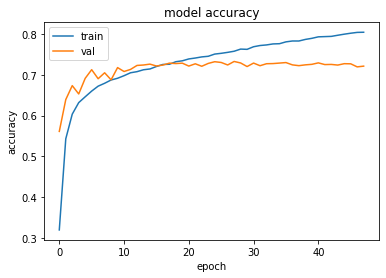

In [25]:
plt.plot(hist_4hl.history['acc'])
plt.plot(hist_4hl.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

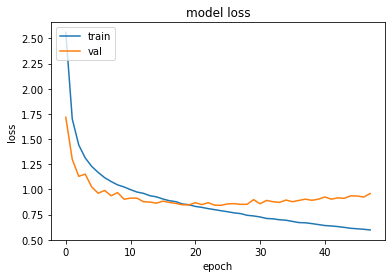

In [26]:
plt.plot(hist_4hl.history['loss'])
plt.plot(hist_4hl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
start = datetime.now()
hist_4hl_a = model_4hl.fit(X, y, validation_split=0.25, epochs=100, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 17s - loss: 2.2668 - acc: 0.4005 - val_loss: 1.3710 - val_acc: 0.6252
Epoch 2/100
 - 10s - loss: 1.4710 - acc: 0.5991 - val_loss: 1.2022 - val_acc: 0.6517
Epoch 3/100
 - 9s - loss: 1.2711 - acc: 0.6409 - val_loss: 1.0095 - val_acc: 0.7037
Epoch 4/100
 - 10s - loss: 1.1620 - acc: 0.6630 - val_loss: 0.9549 - val_acc: 0.7133
Epoch 5/100
 - 9s - loss: 1.0962 - acc: 0.6769 - val_loss: 0.9362 - val_acc: 0.7130
Epoch 6/100
 - 9s - loss: 1.0499 - acc: 0.6870 - val_loss: 0.9087 - val_acc: 0.7175
Epoch 7/100
 - 9s - loss: 1.0112 - acc: 0.6955 - val_loss: 0.8853 - val_acc: 0.7231
Epoch 8/100
 - 9s - loss: 0.9761 - acc: 0.7046 - val_loss: 0.8739 - val_acc: 0.7259
Epoch 9/100
 - 9s - loss: 0.9506 - acc: 0.7111 - val_loss: 0.8647 - val_acc: 0.7243
Epoch 10/100
 - 9s - loss: 0.9261 - acc: 0.7168 - val_loss: 0.8513 - val_acc: 0.7293
Epoch 11/100
 - 9s - loss: 0.9020 - acc: 0.7214 - val_loss: 0.8599 - val_acc: 0.7255
Epoch 12/100
 - 9s - 

'0:07:27.372223'

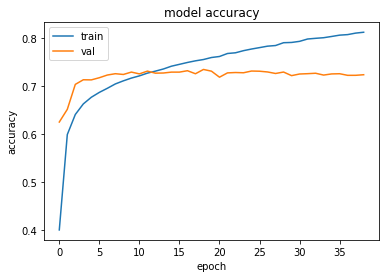

In [31]:
plt.plot(hist_4hl_a.history['acc'])
plt.plot(hist_4hl_a.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

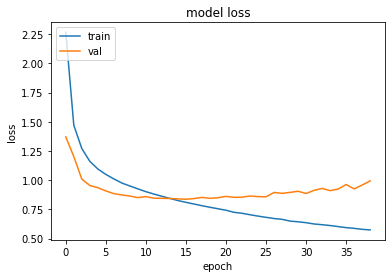

In [32]:
plt.plot(hist_4hl_a.history['loss'])
plt.plot(hist_4hl_a.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

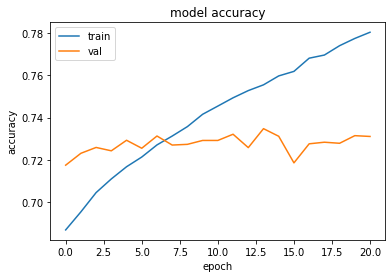

In [33]:
plt.plot(hist_4hl_a.history['acc'][5:26])
plt.plot(hist_4hl_a.history['val_acc'][5:26])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

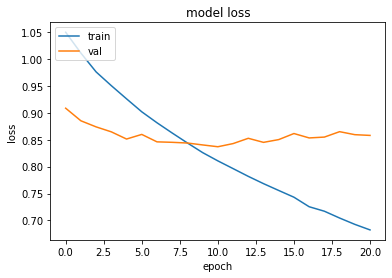

In [34]:
plt.plot(hist_4hl_a.history['loss'][5:26])
plt.plot(hist_4hl_a.history['val_loss'][5:26])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
nn_4hl = KerasClassifier(build_fn=create_model_4hl, epochs=20, batch_size=1000, verbose=2)

In [46]:
scoring = ['accuracy', 'neg_log_loss']
from sklearn.model_selection import cross_validate

In [48]:
start = datetime.now()
hist_cross_val = cross_validate(nn_4hl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=4))
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 10s - loss: 2.2411 - acc: 0.4017
Epoch 2/20
 - 9s - loss: 1.4695 - acc: 0.5995
Epoch 3/20
 - 8s - loss: 1.2570 - acc: 0.6442
Epoch 4/20
 - 8s - loss: 1.1567 - acc: 0.6658
Epoch 5/20
 - 10s - loss: 1.0954 - acc: 0.6793
Epoch 6/20
 - 8s - loss: 1.0434 - acc: 0.6891
Epoch 7/20
 - 8s - loss: 1.0023 - acc: 0.6972
Epoch 8/20
 - 8s - loss: 0.9685 - acc: 0.7057
Epoch 9/20
 - 8s - loss: 0.9443 - acc: 0.7100
Epoch 10/20
 - 8s - loss: 0.9208 - acc: 0.7163
Epoch 11/20
 - 8s - loss: 0.8980 - acc: 0.7220
Epoch 12/20
 - 10s - loss: 0.8804 - acc: 0.7265
Epoch 13/20
 - 11s - loss: 0.8571 - acc: 0.7332
Epoch 14/20
 - 12s - loss: 0.8378 - acc: 0.7370
Epoch 15/20
 - 12s - loss: 0.8217 - acc: 0.7410
Epoch 16/20
 - 10s - loss: 0.8063 - acc: 0.7450
Epoch 17/20
 - 9s - loss: 0.7906 - acc: 0.7502
Epoch 18/20
 - 11s - loss: 0.7774 - acc: 0.7535
Epoch 19/20
 - 10s - loss: 0.7643 - acc: 0.7561
Epoch 20/20
 - 10s - loss: 0.7506 - acc: 0.7603


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 12s - loss: 2.2631 - acc: 0.3973
Epoch 2/20
 - 10s - loss: 1.4859 - acc: 0.5958
Epoch 3/20
 - 10s - loss: 1.2744 - acc: 0.6387
Epoch 4/20
 - 9s - loss: 1.1602 - acc: 0.6652
Epoch 5/20
 - 13s - loss: 1.0953 - acc: 0.6774
Epoch 6/20
 - 10s - loss: 1.0437 - acc: 0.6892
Epoch 7/20
 - 11s - loss: 1.0048 - acc: 0.6969
Epoch 8/20
 - 10s - loss: 0.9712 - acc: 0.7054
Epoch 9/20
 - 9s - loss: 0.9429 - acc: 0.7114
Epoch 10/20
 - 10s - loss: 0.9169 - acc: 0.7179
Epoch 11/20
 - 12s - loss: 0.8978 - acc: 0.7216
Epoch 12/20
 - 10s - loss: 0.8758 - acc: 0.7276
Epoch 13/20
 - 10s - loss: 0.8523 - acc: 0.7328
Epoch 14/20
 - 9s - loss: 0.8358 - acc: 0.7368
Epoch 15/20
 - 9s - loss: 0.8188 - acc: 0.7418
Epoch 16/20
 - 9s - loss: 0.8036 - acc: 0.7461
Epoch 17/20
 - 10s - loss: 0.7859 - acc: 0.7503
Epoch 18/20
 - 13s - loss: 0.7678 - acc: 0.7552
Epoch 19/20
 - 12s - loss: 0.7586 - acc: 0.7583
Epoch 20/20
 - 12s - loss: 0.7466 - acc: 0.7605


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 11s - loss: 2.2171 - acc: 0.4011
Epoch 2/20
 - 11s - loss: 1.4365 - acc: 0.6056
Epoch 3/20
 - 12s - loss: 1.2393 - acc: 0.6469
Epoch 4/20
 - 13s - loss: 1.1437 - acc: 0.6694
Epoch 5/20
 - 13s - loss: 1.0819 - acc: 0.6815
Epoch 6/20
 - 10s - loss: 1.0315 - acc: 0.6934
Epoch 7/20
 - 10s - loss: 0.9933 - acc: 0.7035
Epoch 8/20
 - 10s - loss: 0.9636 - acc: 0.7085
Epoch 9/20
 - 10s - loss: 0.9334 - acc: 0.7149
Epoch 10/20
 - 10s - loss: 0.9091 - acc: 0.7196
Epoch 11/20
 - 10s - loss: 0.8876 - acc: 0.7247
Epoch 12/20
 - 9s - loss: 0.8606 - acc: 0.7316
Epoch 13/20
 - 10s - loss: 0.8457 - acc: 0.7371
Epoch 14/20
 - 11s - loss: 0.8307 - acc: 0.7393
Epoch 15/20
 - 12s - loss: 0.8089 - acc: 0.7461
Epoch 16/20
 - 11s - loss: 0.7922 - acc: 0.7498
Epoch 17/20
 - 12s - loss: 0.7810 - acc: 0.7523
Epoch 18/20
 - 11s - loss: 0.7647 - acc: 0.7552
Epoch 19/20
 - 11s - loss: 0.7522 - acc: 0.7600
Epoch 20/20
 - 11s - loss: 0.7398 - acc: 0.7642


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 14s - loss: 2.2319 - acc: 0.4095
Epoch 2/20
 - 14s - loss: 1.4553 - acc: 0.6005
Epoch 3/20
 - 11s - loss: 1.2564 - acc: 0.6456
Epoch 4/20
 - 12s - loss: 1.1618 - acc: 0.6620
Epoch 5/20
 - 12s - loss: 1.0912 - acc: 0.6776
Epoch 6/20
 - 11s - loss: 1.0475 - acc: 0.6884
Epoch 7/20
 - 11s - loss: 1.0047 - acc: 0.6982
Epoch 8/20
 - 11s - loss: 0.9723 - acc: 0.7052
Epoch 9/20
 - 10s - loss: 0.9490 - acc: 0.7100
Epoch 10/20
 - 10s - loss: 0.9174 - acc: 0.7177
Epoch 11/20
 - 12s - loss: 0.8971 - acc: 0.7207
Epoch 12/20
 - 11s - loss: 0.8756 - acc: 0.7292
Epoch 13/20
 - 11s - loss: 0.8561 - acc: 0.7312
Epoch 14/20
 - 11s - loss: 0.8480 - acc: 0.7327
Epoch 15/20
 - 11s - loss: 0.8296 - acc: 0.7376
Epoch 16/20
 - 10s - loss: 0.8084 - acc: 0.7437
Epoch 17/20
 - 15s - loss: 0.7919 - acc: 0.7488
Epoch 18/20
 - 15s - loss: 0.7843 - acc: 0.7522
Epoch 19/20
 - 14s - loss: 0.7688 - acc: 0.7566
Epoch 20/20
 - 13s - loss: 0.7535 - acc: 0.7595


'0:14:36.481918'

In [49]:
hist_cross_val

{'fit_time': array([190.55857563, 213.8244009 , 221.35653377, 237.76630521]),
 'score_time': array([2.83225417, 3.41089487, 2.74235511, 3.50883722]),
 'test_accuracy': array([0.72034429, 0.72392459, 0.71610772, 0.73404166]),
 'test_neg_log_loss': array([-0.86366527, -0.85815901, -0.92450708, -0.8418027 ])}

In [53]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7236045655224399, -0.8720335169581802)

In [29]:
start = datetime.now()
hist_4hl_b = model_4hl.fit(X, y, validation_split=0.25, epochs=100, batch_size=500, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 12s - loss: 1.9549 - acc: 0.4779 - val_loss: 1.2040 - val_acc: 0.6655
Epoch 2/100
 - 9s - loss: 1.3012 - acc: 0.6353 - val_loss: 1.0282 - val_acc: 0.6960
Epoch 3/100
 - 10s - loss: 1.1540 - acc: 0.6630 - val_loss: 0.9480 - val_acc: 0.7114
Epoch 4/100
 - 10s - loss: 1.0720 - acc: 0.6815 - val_loss: 0.9237 - val_acc: 0.7145
Epoch 5/100
 - 10s - loss: 1.0188 - acc: 0.6942 - val_loss: 0.8943 - val_acc: 0.7237
Epoch 6/100
 - 10s - loss: 0.9779 - acc: 0.7049 - val_loss: 0.8798 - val_acc: 0.7237
Epoch 7/100
 - 9s - loss: 0.9434 - acc: 0.7125 - val_loss: 0.8700 - val_acc: 0.7250
Epoch 8/100
 - 9s - loss: 0.9185 - acc: 0.7176 - val_loss: 0.8651 - val_acc: 0.7237
Epoch 9/100
 - 9s - loss: 0.8894 - acc: 0.7268 - val_loss: 0.8556 - val_acc: 0.7266
Epoch 10/100
 - 10s - loss: 0.8697 - acc: 0.7308 - val_loss: 0.8532 - val_acc: 0.7296
Epoch 11/100
 - 14s - loss: 0.8455 - acc: 0.7364 - val_loss: 0.8559 - val_acc: 0.7287
Epoch 12/100
 - 1

'0:07:08.884566'

In [30]:
start = datetime.now()
hist_4hl_c = model_4hl.fit(X, y, validation_split=0.25, epochs=100, batch_size=3000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 9s - loss: 2.8089 - acc: 0.2677 - val_loss: 1.8294 - val_acc: 0.5051
Epoch 2/100
 - 8s - loss: 1.9019 - acc: 0.4934 - val_loss: 1.3999 - val_acc: 0.6296
Epoch 3/100
 - 8s - loss: 1.6023 - acc: 0.5668 - val_loss: 1.2247 - val_acc: 0.6588
Epoch 4/100
 - 9s - loss: 1.4470 - acc: 0.5999 - val_loss: 1.1395 - val_acc: 0.6795
Epoch 5/100
 - 8s - loss: 1.3352 - acc: 0.6264 - val_loss: 1.0800 - val_acc: 0.6864
Epoch 6/100
 - 9s - loss: 1.2577 - acc: 0.6422 - val_loss: 1.0310 - val_acc: 0.6918
Epoch 7/100
 - 8s - loss: 1.2096 - acc: 0.6521 - val_loss: 1.0218 - val_acc: 0.6873
Epoch 8/100
 - 8s - loss: 1.1562 - acc: 0.6641 - val_loss: 0.9839 - val_acc: 0.6960
Epoch 9/100
 - 8s - loss: 1.1234 - acc: 0.6695 - val_loss: 0.9553 - val_acc: 0.7055
Epoch 10/100
 - 8s - loss: 1.0931 - acc: 0.6758 - val_loss: 0.9509 - val_acc: 0.7050
Epoch 11/100
 - 8s - loss: 1.0715 - acc: 0.6794 - val_loss: 0.9272 - val_acc: 0.7154
Epoch 12/100
 - 8s - los

'0:10:19.688551'